# COMP5331 Group 6 Project: Resilient k-Clustering

In [12]:
from os import mkdir, makedirs
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mount Drive

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/Comp 5331/"
%ls

## Preprocess datasets

In [ ]:
from src.preprocess.process_uber import process_uber
ds_path = "dataset/uber/uber-raw-data-jun14.csv"
save_path = "dataset/uber/"
process_uber(ds_path, save_path)

In [ ]:
from src.preprocess.process_geo import process_geo
ds_names = ["Brightkite", "Gowalla"]
for ds_name in ds_names:
    print(f"Processing {ds_name} dataset")
    ds_path = f"dataset/snap_standford/{ds_name}_totalCheckins.txt"
    save_path = "dataset/snap_standford/"
    process_geo(ds_path, save_path, ds_name)

In [ ]:
from src.preprocess.process_birch import process_birch
ds_name = "birch1"
ds_path = f"dataset/birch/{ds_name}.txt"
save_path = "dataset/birch"
process_birch(ds_path, save_path, ds_name)

In [ ]:
from src.preprocess.process_high_dim import process_high_dim
dims = ['032', '064', '128']

for dim in dims:
    ds_name = "dim"+dim
    ds_path = f"/dataset/high_dim/{ds_name}.txt"
    save_path = "/dataset/high_dim"
    process_high_dim(ds_path, save_path, ds_name)

### Visualize the data

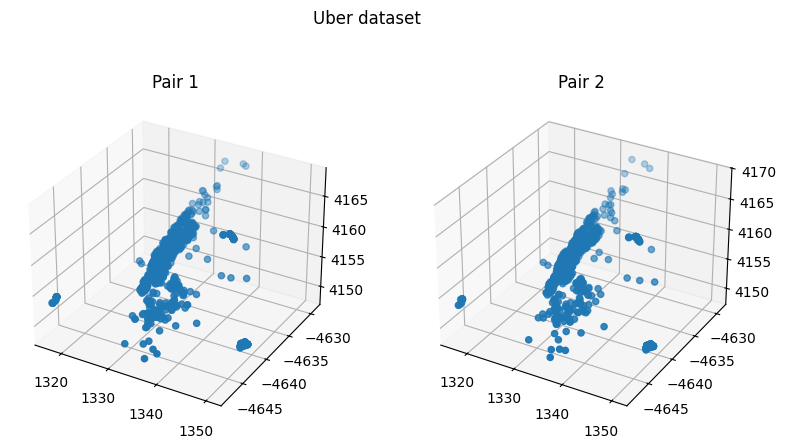

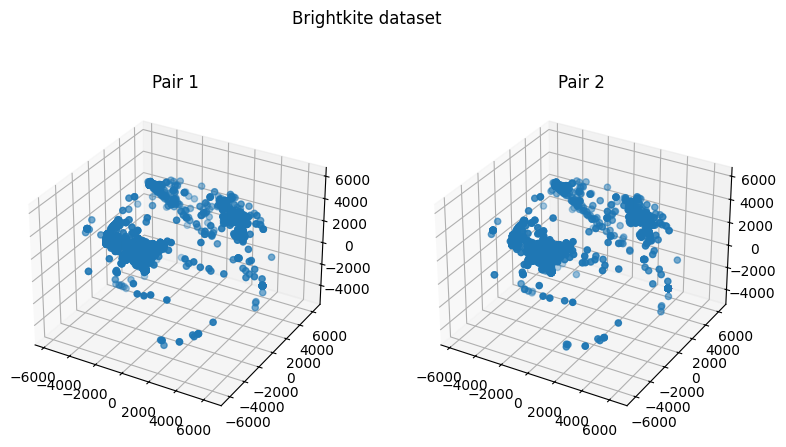

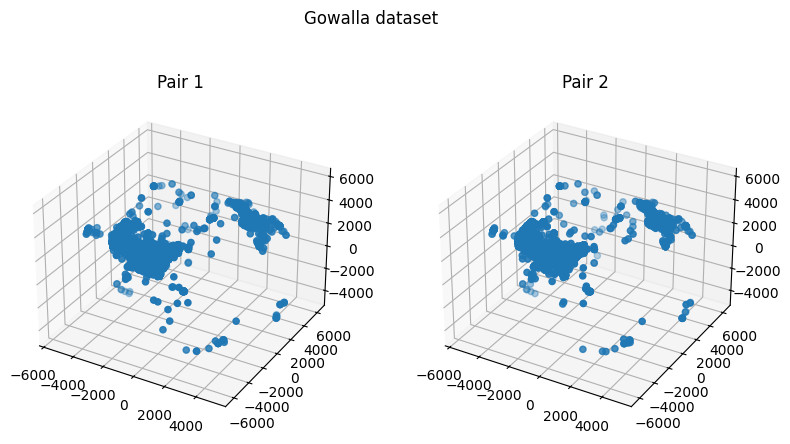

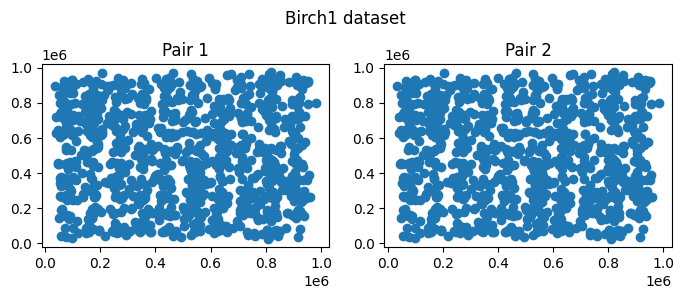

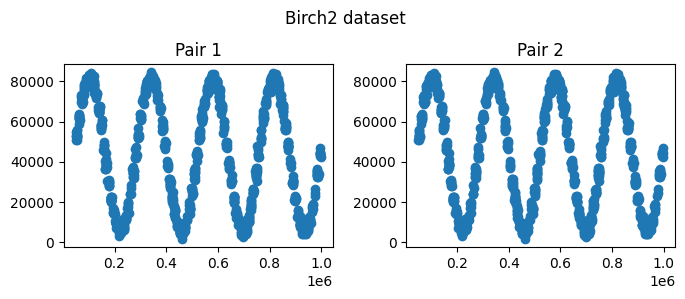

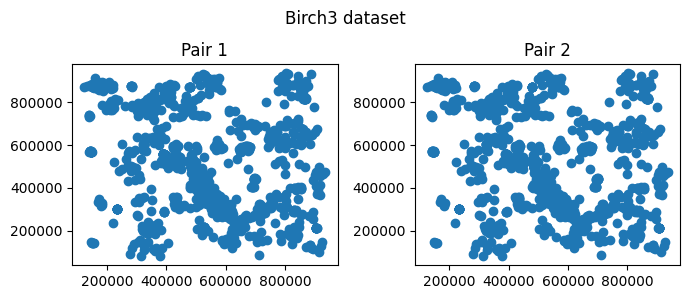

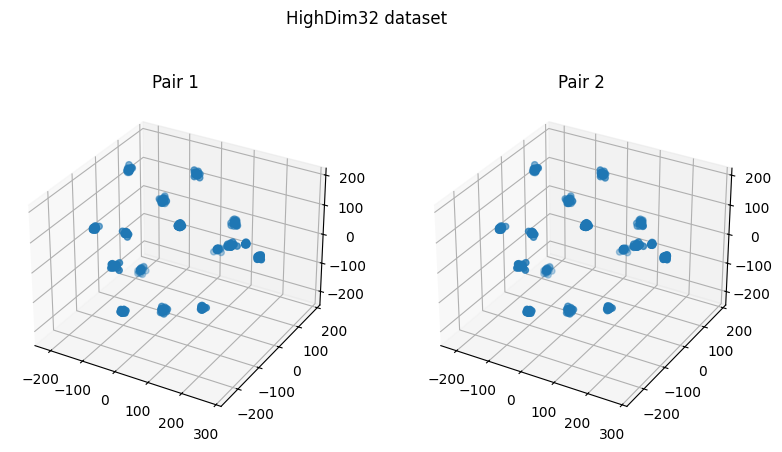

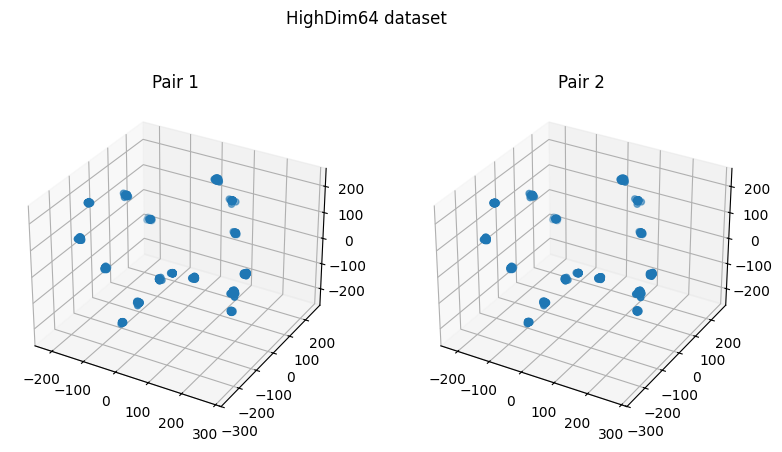

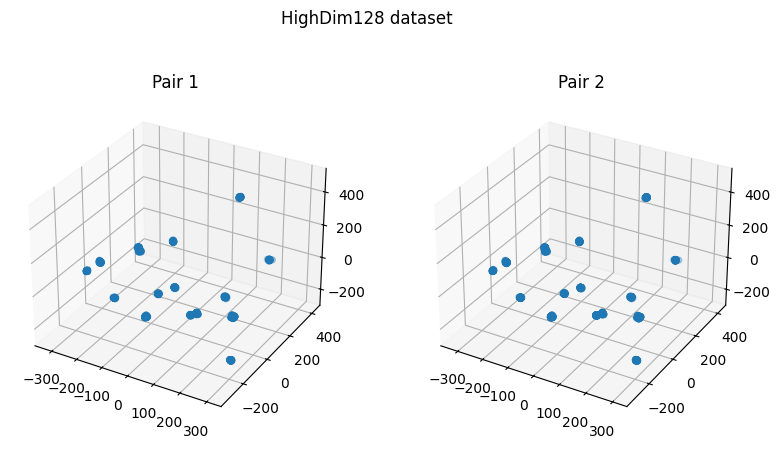

In [13]:
from src.testing.plot_helper import plot_data
from src.datasets import *
from os.path import join, isdir
from os import mkdir
ds_path = "./dataset"
dataset = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=10)
           ]
plot_path = "./dataset/plot"
if not isdir(plot_path):
    mkdir(plot_path)
for ds in dataset:
    pair1, pair2 = ds.load()
    plot_data(pair1, pair2, plot_path, ds.name)

### Calculate possible range for epsilon

In [29]:
from pprint import pprint
def pick_epsilon(lambda_, n):
    epsilion_lower_bound = (3 * np.log(ds.lamb) * np.log(n) ** 2) / n
    epsilion_upper_bound = 1 
    epsilon = np.random.uniform(epsilion_lower_bound, epsilion_upper_bound)
    while (1+epsilon) >= lambda_:
        epsilon = np.random.uniform(epsilion_lower_bound, epsilion_upper_bound)
    
    return epsilon
dataset = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=10)
           ]
# Create epsilon for each lambda and data size combination
eps_dict = {}
for ds in dataset:
    lamb = ds.lamb
    pair1, pair2 = ds.load()
    n = len(pair1)
    if lamb == 1.1:
        epsilon = 0.05
    elif lamb == 1.001:
        epsilon = 0.0005
    eps_dict[(lamb,n)] = epsilon
pprint(eps_dict)


{(1.001, 6265): 0.0005,
 (1.1, 1000): 0.05,
 (1.1, 1024): 0.05,
 (1.1, 1090): 0.05,
 (1.1, 2267): 0.05}


## Experiment

### k-resillient

In [30]:
import numpy as np
from src.resilient_k import resilient_k_center
from src.datasets import *
from os.path import join, isdir
from os import mkdir, makedirs
from src.testing.plot_helper import plot_cluster_result
import pickle
import random
#import time

In [31]:
def experiment(ds, resilient_k_param, plot_path, result_path, epsilon = 0.3):
    for algo in resilient_k_param["algorithm"]:
        for alpha in resilient_k_param["alpha"]:
            for beta in resilient_k_param["beta"]:  
                for seed in resilient_k_param["seed"]:   
                
                    print(f"Processing {ds.name} dataset with k={ds.k}, lamb={ds.lamb}, alpha={alpha}, beta={beta}, algorithm={algo}, seed={seed}")
                    pair1, pair2 = ds.load()                    
                    
                    model1 = resilient_k_center(pair1, k=ds.k, lamb=ds.lamb, epsilon=epsilon, alpha=alpha, beta=beta, algorithm=algo, seed=seed)
                    #start_time = time.process_time_ns()
                    center1, cluster1 = model1.resilient_k_center(seed=seed)
                    #end_time = time.process_time_ns()
                    #time_taken1 = end_time - start_time
                    
                    model2 = resilient_k_center(pair2, k=ds.k, lamb=ds.lamb, epsilon=epsilon, alpha=alpha, beta=beta, algorithm=algo, seed=seed)
                    #start_time = time.process_time_ns()
                    center2, cluster2 = model2.resilient_k_center(seed=seed)
                    #end_time = time.process_time_ns()
                    #time_taken2 = end_time - start_time
                    seed_result_path = join(result_path, f'{seed}')
                    if not isdir(seed_result_path):
                        mkdir(seed_result_path)
                    this_result_path = join(seed_result_path, f'{ds.name}')
                    if not isdir(this_result_path):
                        mkdir(this_result_path)
                        
                    with open(join(this_result_path, f"{ds.name}_resilient_{ds.k}_{algo}({alpha}_{beta}).pickle"), 'wb') as output_file:
                        #pickle.dump((center1, cluster1, center2, cluster2, time_taken1, time_taken2), output_file)
                        pickle.dump((center1, cluster1, center2, cluster2), output_file)
                        
                    pt1 = np.asarray([c[0] for c in cluster1])
                    pt2 = np.asarray([c[0] for c in cluster2])
                    label1 = [c[1] for c in cluster1]
                    label2 = [c[1] for c in cluster2]
                    
                    seed_plot_path = join(plot_path, f'{seed}')
                    if not isdir(seed_plot_path):
                        mkdir(seed_plot_path)
                    this_plot_path = join(seed_plot_path, ds.name)
                    if not isdir(this_plot_path):
                        mkdir(this_plot_path)
                        
                    # plot_cluster_result(pt1, pt2, label1, label2, this_plot_path, ds, algo, alpha, beta)

In [32]:
ds_path = "./dataset"
resilient_k_param ={"alpha": [0.5, 1.0], 
                    "beta": [0.5, 1.0],
                    "algorithm": ["gonz", "carv"],
                    "seed": [5331,5332,5333]}
plot_path = "./results/plot/resilient_k/"
result_path = "./results/resilient_k/"
if not isdir(plot_path):
    makedirs(plot_path)
if not isdir(result_path):
    makedirs(result_path)

#### 1. Uber

In [34]:
dataset = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10),
           Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=20)]

for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, result_path, epsilon=eps_dict[(ds.lamb, len(pair1))])

Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz, seed=5331
Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz, seed=5332
Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz, seed=5333
Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz, seed=5331
Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz, seed=5332
Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz, seed=5333
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz, seed=5331
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz, seed=5332
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz, seed=5333
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz, seed=5331
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz

#### 2. Brightkite

In [ ]:
dataset = [Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=100)]#,
           #Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50),
           #Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=100)]

for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, result_path)

#### 3. Birch

In [ ]:
dataset = [Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=20)]

for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, result_path, epsilon=eps_dict[(ds.lamb, len(pair1))])

#### 4.High dim 

In [ ]:
dataset = [HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=20)]
for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, result_path)

## Evalutaion

In [137]:
from src.evaluation import Metrics, Clustering
from src.testing.find_pair_assignment import find_pair_assign
from os.path import join, isdir, isfile
from os import mkdir
from src.datasets import *
import pickle

In [5]:
ds_path = "./dataset"
resilient_k_param ={"alpha": [0.5, 1.0], 
                    "beta": [0.5, 1.0],
                    "algorithm": ["gonz", "carv"]}

to_eval = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10),
           Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=20),
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=100),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=20), 
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=20) 
           ]
result_path = "./results/baseline"

### Baseline

#### 1. Gonz algorithm

In [37]:
from src.evaluation import GonzalezAlgorithm, Gonz_Approx_Algo

for ds in to_eval:
    for seed in [5331, 5332, 5333]:
        print(f"Processing {ds.name} dataset with k={ds.k}, algorithm=gonz_only")
        pair1, pair2 = ds.load()
        model1 = Gonz_Approx_Algo(pair1, ds.k, seed)
        center1, cluster1 = model1.clustering()
        model2 = Gonz_Approx_Algo(pair2, ds.k, seed)
        center2, cluster2 = model2.clustering()
        result_path = "./results/baseline"
        result_path = join(result_path, f'{seed}')
        if not isdir(result_path):
            mkdir(result_path)
        with open(join(result_path, f"{ds.name}_resilient_{ds.k}_gonz_only.pickle"), 'wb') as output_file:
            pickle.dump((center1, cluster1, center2, cluster2), output_file)

Processing Uber dataset with k=10, algorithm=gonz_only
Processing Uber dataset with k=10, algorithm=gonz_only
Processing Uber dataset with k=10, algorithm=gonz_only
Processing Uber dataset with k=20, algorithm=gonz_only
Processing Uber dataset with k=20, algorithm=gonz_only
Processing Uber dataset with k=20, algorithm=gonz_only
Processing Brightkite dataset with k=50, algorithm=gonz_only
Processing Brightkite dataset with k=50, algorithm=gonz_only
Processing Brightkite dataset with k=50, algorithm=gonz_only
Processing Brightkite dataset with k=100, algorithm=gonz_only
Processing Brightkite dataset with k=100, algorithm=gonz_only
Processing Brightkite dataset with k=100, algorithm=gonz_only
Processing Birch1 dataset with k=10, algorithm=gonz_only
Processing Birch1 dataset with k=10, algorithm=gonz_only
Processing Birch1 dataset with k=10, algorithm=gonz_only
Processing Birch1 dataset with k=20, algorithm=gonz_only
Processing Birch1 dataset with k=20, algorithm=gonz_only
Processing Birch

#### 2. Carve algorithm only

In [38]:
from src.evaluation import CarvingAlgorithm
result_path = "./results/baseline/carve/"
for ds in to_eval:
    for seed in [5331, 5332, 5333]:
        print(f"Processing {ds.name} dataset with k={ds.k}, algorithm=gonz_only")
        pair1, pair2 = ds.load()
        
        model1 = CarvingAlgorithm(pair1, seed=seed)
        best_r = model1.find_minimum_R(ds.k)
        center1, cluster1 = model1.carve(best_r, ds.k)
        model2 = CarvingAlgorithm(pair2, seed=seed)
        best_r = model2.find_minimum_R(ds.k)
        center2, cluster2 = model2.carve(best_r, ds.k)
        result_path = "./results/baseline"
        result_path = join(result_path, f'{seed}')
        if not isdir(result_path):
            mkdir(result_path)
        with open(join(result_path, f"{ds.name}_resilient_{ds.k}_carve_only.pickle"), 'wb') as output_file:
            pickle.dump((center1, cluster1, center2, cluster2), output_file)

Processing Uber dataset with k=10, algorithm=gonz_only
Best R:  5.0
Best R:  5.0
Processing Uber dataset with k=10, algorithm=gonz_only
Best R:  5.0
Best R:  5.0
Processing Uber dataset with k=10, algorithm=gonz_only
Best R:  5.0
Best R:  6.0
Processing Uber dataset with k=20, algorithm=gonz_only
Best R:  3.0
Best R:  3.0
Processing Uber dataset with k=20, algorithm=gonz_only
Best R:  3.0
Best R:  3.0
Processing Uber dataset with k=20, algorithm=gonz_only
Best R:  3.0
Best R:  3.0
Processing Brightkite dataset with k=50, algorithm=gonz_only
Best R:  1414.0
Best R:  1330.0
Processing Brightkite dataset with k=50, algorithm=gonz_only
Best R:  1365.0
Best R:  1308.0
Processing Brightkite dataset with k=50, algorithm=gonz_only
Best R:  1365.0
Best R:  1309.0
Processing Brightkite dataset with k=100, algorithm=gonz_only
Best R:  803.0
Best R:  738.0
Processing Brightkite dataset with k=100, algorithm=gonz_only
Best R:  796.0
Best R:  741.0
Processing Brightkite dataset with k=100, algorithm

#### 3. HS algorithm only

In [39]:
from src.evaluation import HSAlgorithm

for ds in to_eval:
    for seed in [5331, 5332, 5333]:
        print(f"Processing {ds.name} dataset with k={ds.k}, algorithm=gonz_only")
        pair1, pair2 = ds.load()
        
        model1 = HSAlgorithm(pair1,ds.k)
        center1, cluster1 = model1.hs_algorithm(pair1, ds.k, seed=seed)
        model2 = HSAlgorithm(pair1,ds.k)
        center2, cluster2 = model2.hs_algorithm(pair2, ds.k, seed=seed)
        result_path = "./results/baseline"
        result_path = join(result_path, f'{seed}')
        if not isdir(result_path):
            mkdir(result_path)
        with open(join(result_path, f"{ds.name}_resilient_{ds.k}_hs_only.pickle"), 'wb') as output_file:
            pickle.dump((center1, cluster1, center2, cluster2), output_file)

Processing Uber dataset with k=10, algorithm=gonz_only
Processing Uber dataset with k=10, algorithm=gonz_only
Processing Uber dataset with k=10, algorithm=gonz_only
Processing Uber dataset with k=20, algorithm=gonz_only
Processing Uber dataset with k=20, algorithm=gonz_only
Processing Uber dataset with k=20, algorithm=gonz_only
Processing Brightkite dataset with k=50, algorithm=gonz_only
Processing Brightkite dataset with k=50, algorithm=gonz_only
Processing Brightkite dataset with k=50, algorithm=gonz_only
Processing Brightkite dataset with k=100, algorithm=gonz_only
Processing Brightkite dataset with k=100, algorithm=gonz_only
Processing Brightkite dataset with k=100, algorithm=gonz_only
Processing Birch1 dataset with k=10, algorithm=gonz_only
Processing Birch1 dataset with k=10, algorithm=gonz_only
Processing Birch1 dataset with k=10, algorithm=gonz_only
Processing Birch1 dataset with k=20, algorithm=gonz_only
Processing Birch1 dataset with k=20, algorithm=gonz_only
Processing Birch

### Visualization
Use directory structure from one drive for results

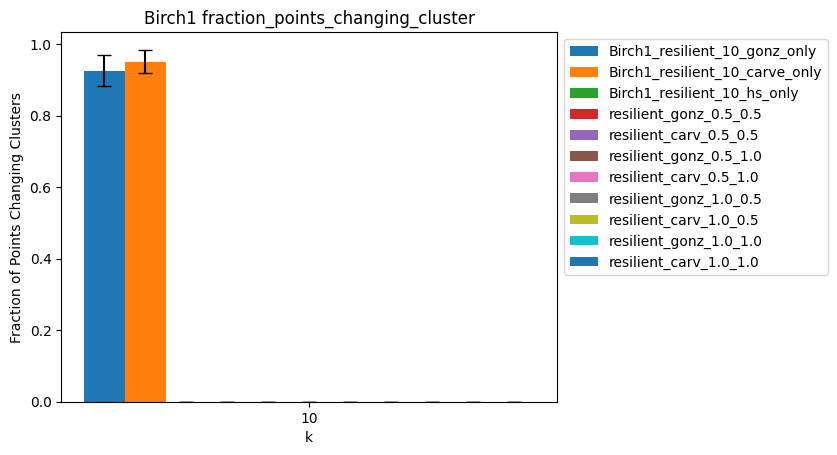

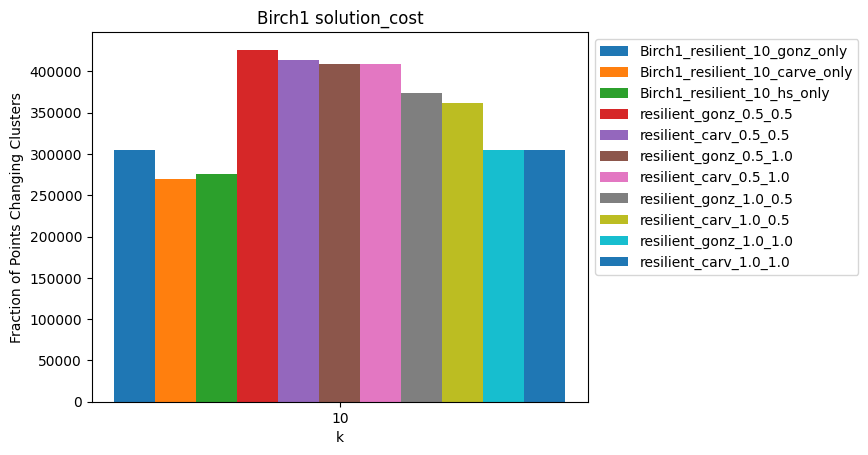

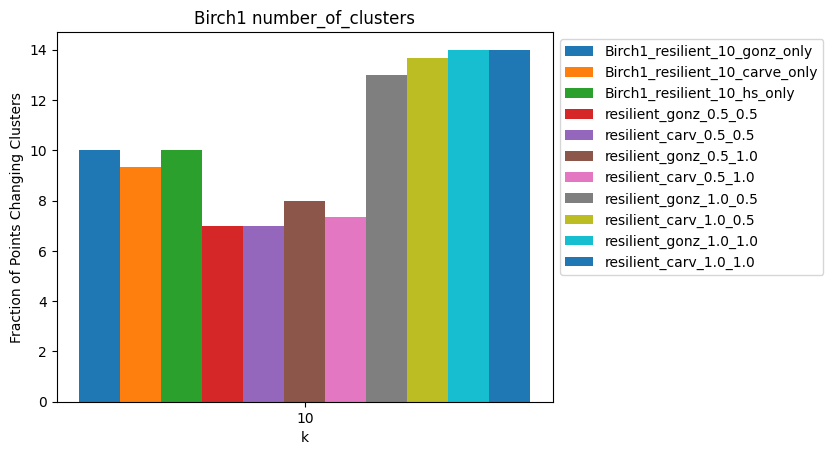

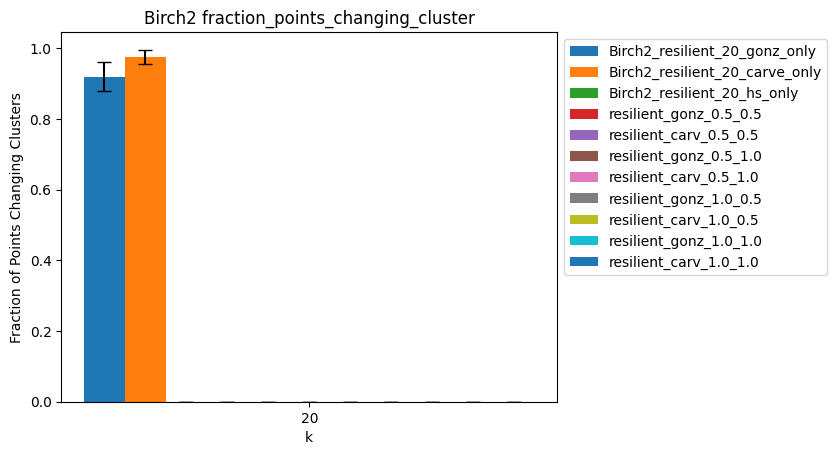

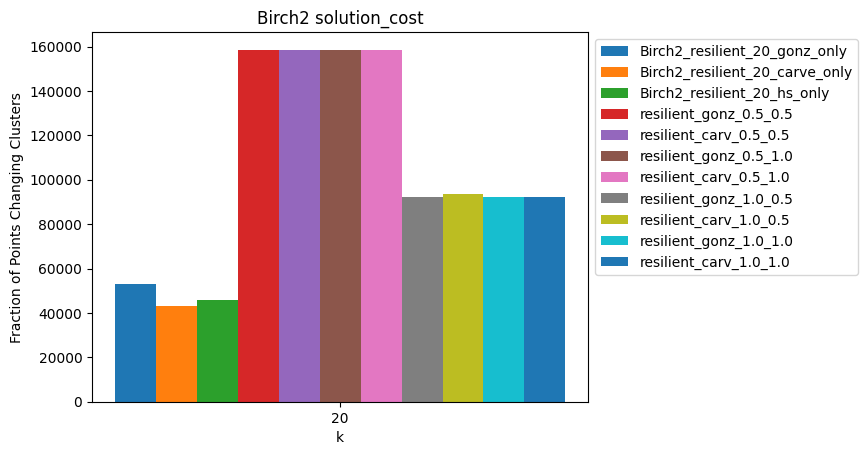

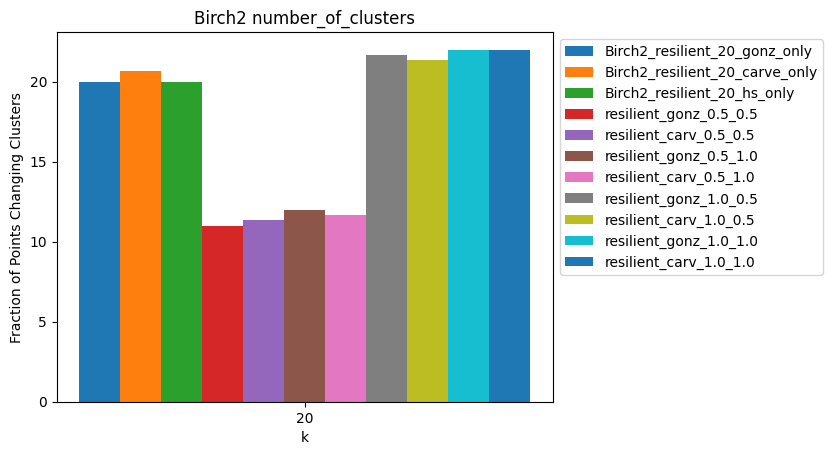

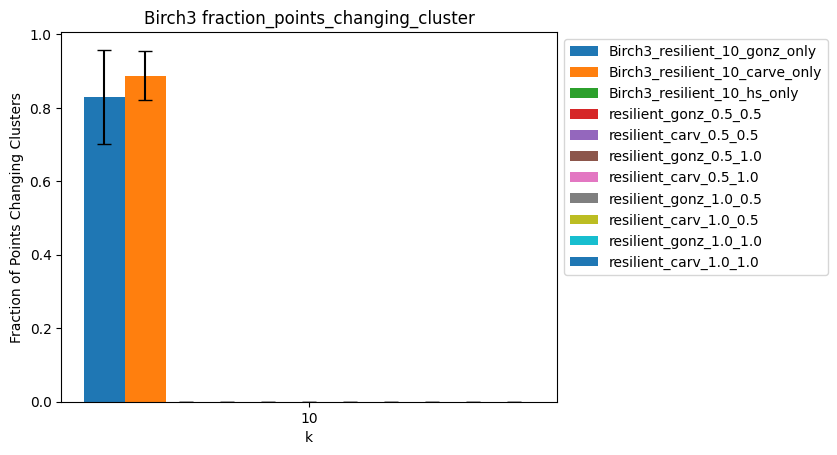

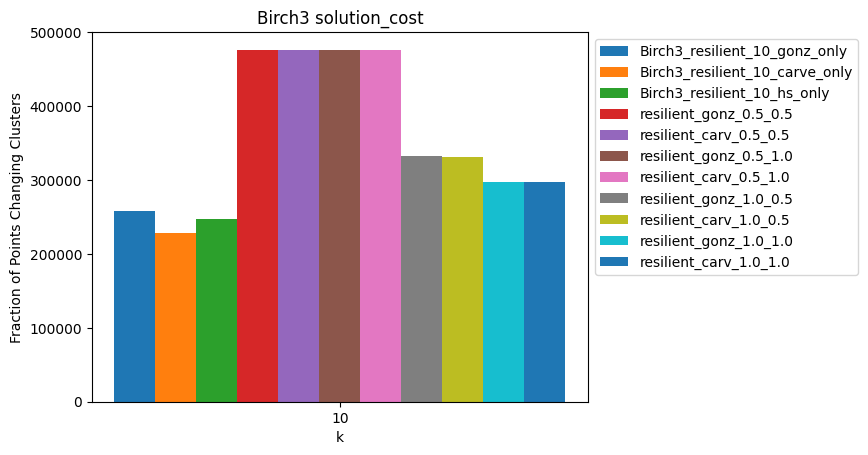

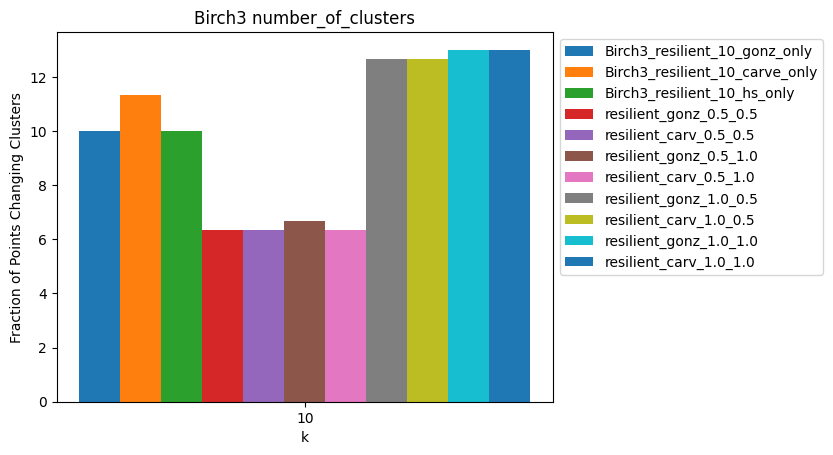

FileNotFoundError: [Errno 2] No such file or directory: './results/resilient_k/5331/Brightkite/Brightkite_resilient_50_gonz(0.5_0.5).pickle'

In [41]:


from src.evaluation import Metrics, Clustering
from src.testing.find_pair_assignment import find_pair_assign
from os.path import join, isdir, isfile
from os import mkdir
from src.datasets import *
from pprint import pprint
import pickle
import matplotlib.pyplot as plt
results ={
    # dataset : k, seed, a, b (need to access resilient and baseline)
    'Birch1': [[10],[5331,5332,5333], (0.5, 1.0), (0.5, 1.0)],
    'Birch2': [[20],[5331,5332,5333], (0.5, 1.0), (0.5, 1.0)],
    'Birch3': [[10],[5331,5332,5333], (0.5, 1.0), (0.5, 1.0)],
    # 'Brightkite': [[50,100],[5331,5332,5333], (0.5, 1.0), (0.5, 1.0)],
    # 'HighDim32' : [[10,20],[5331,5332,5333], (0.5, 1.0), (0.5, 1.0)],
    # 'HighDim64' : [[10,20],[5331,5332,5333], (0.5, 1.0), (0.5, 1.0)],
    # 'HighDim128' : [[10,20],[5331,5332,5333], (0.5, 1.0), (0.5, 1.0)],
    'Uber': [[10, 20], [5331,5332,5333], (0.5, 1.0), (0.5, 1.0)]
}
resilient_k_models = ["gonz", "carv"]
baseline_models = ["gonz", "carve", "hs"]
cluster_results = {}
metric = Metrics()
for ds_name, params in results.items():
    cluster_result = {}
    # 1 plot for each k
    for k in params[0]:
        cluster_result[k] = {}
            # get baseline model here
        for model in baseline_models:
            model_result = {}
            fraction_result_list = []
            sol_cost_result_list = []
            num_cluster_result_list = []
            for seed in params[1]:
                result_path = f"./results/baseline/{seed}/"
                with open(join(result_path, f"{ds_name}_resilient_{k}_{model}_only.pickle"), 'rb') as input_file:
                    center1, cluster1, center2, cluster2 = pickle.load(input_file)
                    cluster1 = [(c[0], np.array([[c[1]]])) for c in cluster1]
                    cluster2 = [(c[0], np.array([[c[1]]])) for c in cluster2]
                    fraction_changed, sol_cost, num_cluster = metric.evaluate(old_points=cluster1, old_medoids=center1, new_points=cluster2, new_medoids=center2, epsilon=0.3)
                    # print(num_cluster)
                    fraction_result_list.append(fraction_changed)
                    sol_cost_result_list.append(sol_cost[1])
                    num_cluster_result_list.append(num_cluster[1])
                    # print(sol_cost)
                    # print(num_cluster)
                    # d
            fraction_result_list = np.array(fraction_result_list)
            sol_cost_result_list = np.array(sol_cost_result_list)
            num_cluster_result_list = np.array(num_cluster_result_list)
            
            fraction_mean, fraction_std = np.mean(fraction_result_list), np.std(fraction_result_list)
            sol_cost_mean, sol_cost_std = np.mean(sol_cost_result_list, axis=0), np.std(sol_cost_result_list, axis=0)
            num_cluster_mean, num_cluster_std = np.mean(num_cluster_result_list, axis=0), np.std(num_cluster_result_list, axis=0)
                
            cluster_result[k][f"{ds_name}_resilient_{k}_{model}_only"] = {
                        "fraction_points_changing_cluster": [fraction_mean, fraction_std],
                        "solution_cost": [sol_cost_mean, sol_cost_std],
                        "number_of_clusters": [num_cluster_mean, num_cluster_std]
                    }
            
            # construct resilient model result below
        # for 1 model result below
        for a in params[2]:
            for b in params[3]:
                for model in resilient_k_models:
                    fraction_result_list = []
                    sol_cost_result_list = []
                    num_cluster_result_list = []
                    for seed in params[1]:
                        result_path = f"./results/resilient_k/{seed}/{ds_name}/"
                        with open(join(result_path, f"{ds_name}_resilient_{k}_{model}({a}_{b}).pickle"), 'rb') as input_file:
                            center1, cluster1, center2, cluster2 = pickle.load(input_file)
                        fraction_changed, sol_cost, num_cluster = metric.evaluate(old_points=cluster1, old_medoids=center1, new_points=cluster2, new_medoids=center2, epsilon=0.3)

                        fraction_result_list.append(fraction_changed)
                        sol_cost_result_list.append(sol_cost[1])
                        num_cluster_result_list.append(num_cluster[1])
                        
                    fraction_result_list = np.array(fraction_result_list)
                    sol_cost_result_list = np.array(sol_cost_result_list)
                    num_cluster_result_list = np.array(num_cluster_result_list)
                    
                    fraction_mean, fraction_std = np.mean(fraction_result_list), np.std(fraction_result_list)
                    sol_cost_mean, sol_cost_std = np.mean(sol_cost_result_list, axis=0), np.std(sol_cost_result_list, axis=0)
                    num_cluster_mean, num_cluster_std = np.mean(num_cluster_result_list, axis=0), np.std(num_cluster_result_list, axis=0)
                        
                    cluster_result[k][f'resilient_{model}_{a}_{b}'] = {
                                "fraction_points_changing_cluster": [fraction_mean, fraction_std],
                                "solution_cost": [sol_cost_mean, sol_cost_std],
                                "number_of_clusters": [num_cluster_mean, num_cluster_std]
                            }
    
    for key in ["fraction_points_changing_cluster"]:
        model_results_means= []
        model_results_stds = []
        model_name_list = []
        # get model name
        for k in cluster_result:
            for model in cluster_result[k]:
                model_name_list.append(model)
            break
        for k in cluster_result:
            model_result_mean = []
            model_result_std = []
            for model in cluster_result[k]:
                
                model_result_mean.append(cluster_result[k][model][key][0])
                model_result_std.append(cluster_result[k][model][key][1])
            model_results_means.append(model_result_mean)
            model_results_stds.append(model_result_std)
        means = np.vstack(model_results_means).T
        stds = np.vstack(model_results_stds).T
        
        x = np.arange(len(cluster_result))  # the label locations
        width = 0.075  # the width of the bars

        # Create bars for each set of data
        for i, (fraction, error) in enumerate(zip(means, stds)):
            plt.bar(x + i * width, fraction, width, label=model_name_list[i], yerr=error, capsize=5)

        # Add some text for labels, title, and custom x-axis tick labels, etc.
        plt.xlabel('k')
        plt.ylabel('Fraction of Points Changing Clusters')
        plt.title(f'{ds_name} {key}')
        plt.xticks(x + width * (len(model_name_list) - 1) / 2, cluster_result.keys())
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

        # Show the plot
        # plt.tight_layout()
        plt.savefig(f"{ds_name}_{key}.png")
        plt.show()       
    for key in ["solution_cost", "number_of_clusters"]:
        model_results_means= []
        model_results_stds = []
        model_name_list = []
        # get model name
        for k in cluster_result:
            for model in cluster_result[k]:
                model_name_list.append(model)
            break
        for k in cluster_result:
            model_result_mean = []
            model_result_std = []
            for model in cluster_result[k]:
                
                model_result_mean.append(cluster_result[k][model][key][0])
                model_result_std.append(cluster_result[k][model][key][1])
            model_results_means.append(model_result_mean)
            model_results_stds.append(model_result_std)
        means = np.vstack(model_results_means).T
        stds = np.vstack(model_results_stds).T
        
        x = np.arange(len(cluster_result))  # the label locations
        width = 0.075  # the width of the bars

        # Create bars for each set of data
        for i, fraction in enumerate(means):
            plt.bar(x + i * width, fraction, width, label=model_name_list[i], capsize=5)

        # Add some text for labels, title, and custom x-axis tick labels, etc.
        plt.xlabel('k')
        plt.ylabel('Fraction of Points Changing Clusters')
        plt.title(f'{ds_name} {key}')
        plt.xticks(x + width * (len(model_name_list) - 1) / 2, cluster_result.keys())
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

        # Show the plot
        # plt.tight_layout()
        plt.savefig(f"{ds_name}_{key}.png")
        plt.show()             
    cluster_results[ds_name] = cluster_result                     